# Visualize Filters

The first thing we'd like to do is visualize what's going on in a trained neural network. We're interested in:

- The weights of the kernel
- Patterns this kernel responds to

In [19]:
import torch
from fastai.vision import *
from fastai.vision.models import resnet50

import matplotlib.pyplot as plt

In [20]:
model = resnet50(pretrained=True)

In [21]:
# This is the layer we're interested in:
print(model.conv1.weight.shape)

torch.Size([64, 3, 7, 7])


## Visualizing the Weights

So we've got 64 filters, each with a height and width of 7 and a depth of 3. What does one of these look like?

In [22]:
torch.set_printoptions(precision=1) # Rounding for the sake of presentation
model.conv1.weight.detach()[0]

tensor([[[ 0.0,  0.0, -0.0, -0.0, -0.0, -0.0, -0.1],
         [ 0.0,  0.0,  0.0,  0.0,  0.0, -0.0, -0.0],
         [ 0.0,  0.0,  0.0,  0.1,  0.1,  0.1,  0.1],
         [ 0.0,  0.0, -0.0, -0.0, -0.0,  0.0,  0.1],
         [-0.0,  0.0, -0.0, -0.1, -0.1, -0.1,  0.0],
         [ 0.0,  0.0,  0.1,  0.1,  0.0, -0.0, -0.0],
         [-0.1, -0.0, -0.0,  0.0,  0.0,  0.0,  0.0]],

        [[-0.0,  0.0,  0.0,  0.1,  0.1,  0.0, -0.0],
         [-0.0,  0.0,  0.1,  0.1,  0.2,  0.1,  0.1],
         [-0.0, -0.1, -0.1, -0.0,  0.1,  0.2,  0.2],
         [-0.0, -0.1, -0.2, -0.3, -0.3, -0.1,  0.0],
         [ 0.0,  0.0, -0.1, -0.2, -0.4, -0.3, -0.1],
         [ 0.1,  0.1,  0.2,  0.1, -0.0, -0.1, -0.1],
         [-0.0,  0.1,  0.1,  0.2,  0.2,  0.1,  0.0]],

        [[-0.0, -0.0,  0.0,  0.0,  0.0,  0.0, -0.0],
         [-0.0,  0.0,  0.0,  0.1,  0.1,  0.1,  0.1],
         [-0.1, -0.1, -0.1, -0.0,  0.1,  0.1,  0.1],
         [-0.0, -0.1, -0.2, -0.3, -0.2, -0.1,  0.0],
         [ 0.0,  0.0, -0.1, -0.2, -0.3, -0

This is interesting, but it's hard for us to look at this and see anything useful. Let's try plotting the weights as 3x7x7 images.

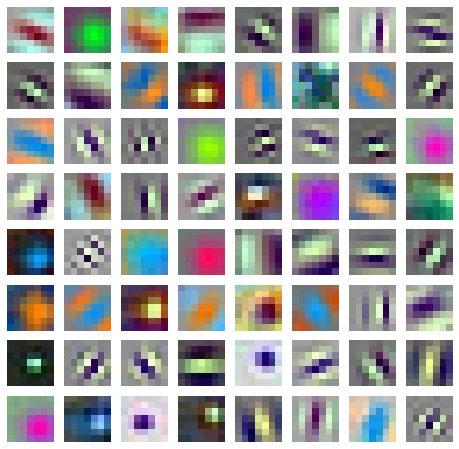

In [23]:
# visualize filters as 3x7x7 RGB images
filters = model.conv1.weight.detach().permute((0, 2, 3, 1))

rows = 8
cols = 8

fig = plt.figure(figsize=(8, 8))


for i in range(1, cols*rows + 1):

    fig.add_subplot(rows, cols, i)
    
    weights = filters[i - 1]
    min = weights.min()
    max = weights.max()
    normalized = (weights - min)/(max - min)
    plt.axis('off')
    plt.imshow(normalized)

Much better! Some of these show clear patterns and probably respond to lines and edges in the input. It's not super easy for us to know what they all do though.

One thought: Perhaps it's worth visualizing the weights as three sets of 7x7 grayscale images instead of 3x7x7 RGB images. Maybe one filter is useful for the green channel, but noise for red and blue?

In [51]:
r_mean = filters[0][0].std()
g_mean = filters[0][1].std()
b_mean = filters[0][2].std()

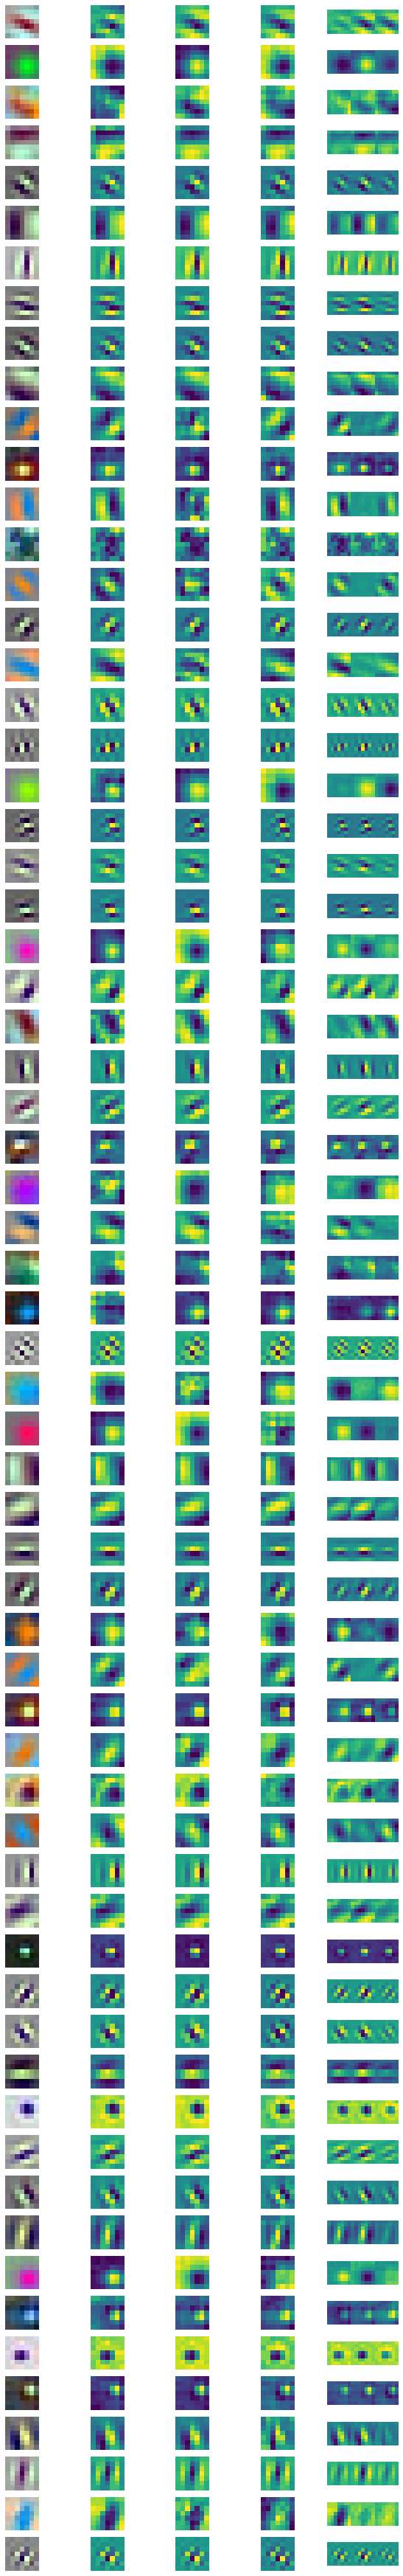

In [48]:
# visualize filters as 3x7x7 RGB images
filters = model.conv1.weight.detach().permute((0, 2, 3, 1))

rows = 64
cols = 5

fig = plt.figure(figsize=(10, 64))

for i in range(1, rows + 1):

    index = (i - 1) * cols
    
    weights = filters[i - 1]
    red = weights[:,:,0]
    green = weights[:,:,1]
    blue = weights[:,:,2]
    
    normalized = (weights - weights.min())/(weights.max() - weights.min())
    normalized_red   = (red - weights.min()) / (weights.max() - weights.min())
    normalized_green = (green - weights.min()) / (weights.max() - weights.min())
    normalized_blue  = (blue - weights.min()) / (weights.max() - weights.min())
    
    # Individual plots
    fig.add_subplot(rows, cols, index + 1)
    plt.axis('off')
    plt.imshow(normalized)
    fig.add_subplot(rows, cols, index + 2)
    plt.axis('off')
    plt.imshow(normalized_red)
    fig.add_subplot(rows, cols, index + 3)
    plt.axis('off')
    plt.imshow(normalized_green)
    fig.add_subplot(rows, cols, index + 4)
    plt.axis('off')
    plt.imshow(normalized_blue)
    
    # Stacked plot to better show differences in magnitude between red, green and blue filters
    stacked_filters = np.hstack((normalized_red, normalized_green, normalized_blue))
    fig.add_subplot(rows, cols, index + 5)
    plt.axis('off')
    plt.imshow(stacked_filters)

So it looks like most of the filters have similar weights across all three channels, but there are definitely some that have different weights for different channels. I don't have a strong intuition about what this means or if it's important, but we'll make a mental note of it.

## Feature Visualization

Now that we've seen the weights, let's try to get an idea about what each filter responds to.

100%|██████████| 512/512 [00:53<00:00,  9.50it/s]


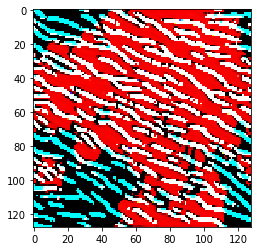

100%|██████████| 512/512 [00:55<00:00,  9.16it/s]


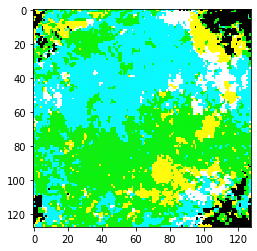

100%|██████████| 512/512 [00:56<00:00,  9.09it/s]


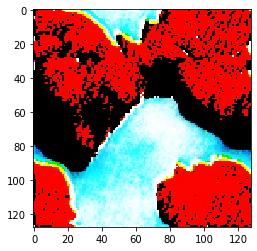

In [42]:
from lucent.optvis import render
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device).eval()

# Get the first three visualizations
for i in range(3):
    result = render.render_vis(model, "relu:" + str(i))
    plt.imshow(result[0][0])
    plt.show()

In [59]:
result = render.render_vis(model, "relu:" + str(61))



  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 1/512 [00:00<01:10,  7.26it/s]

  0%|          | 2/512 [00:00<01:07,  7.55it/s]

  1%|          | 3/512 [00:00<01:04,  7.91it/s]

  1%|          | 4/512 [00:00<01:04,  7.88it/s]

  1%|          | 5/512 [00:00<01:03,  8.02it/s]

  1%|          | 6/512 [00:00<01:01,  8.28it/s]

  1%|▏         | 7/512 [00:00<01:02,  8.05it/s]

  2%|▏         | 8/512 [00:01<01:05,  7.75it/s]

  2%|▏         | 9/512 [00:01<01:01,  8.22it/s]

  2%|▏         | 10/512 [00:01<01:01,  8.13it/s]

  2%|▏         | 11/512 [00:01<01:01,  8.09it/s]

  2%|▏         | 12/512 [00:01<01:00,  8.27it/s]

  3%|▎         | 13/512 [00:01<00:58,  8.50it/s]

  3%|▎         | 14/512 [00:01<01:03,  7.80it/s]

  3%|▎         | 15/512 [00:01<01:04,  7.68it/s]

  3%|▎         | 16/512 [00:01<01:04,  7.73it/s]

  3%|▎         | 17/512 [00:02<01:01,  8.03it/s]

  4%|▎         | 18/512 [00:02<01:03,  7.77it/s]

  4%|▎         | 19/512 [00:02<01:01,  8.05it/s]

  4%|▍         |

 31%|███       | 157/512 [00:18<00:40,  8.82it/s]

 31%|███       | 159/512 [00:18<00:39,  9.00it/s]

 31%|███▏      | 161/512 [00:18<00:36,  9.50it/s]

 32%|███▏      | 162/512 [00:18<00:37,  9.43it/s]

 32%|███▏      | 163/512 [00:18<00:37,  9.36it/s]

 32%|███▏      | 164/512 [00:18<00:38,  9.14it/s]

 32%|███▏      | 166/512 [00:18<00:36,  9.40it/s]

 33%|███▎      | 167/512 [00:19<00:37,  9.30it/s]

 33%|███▎      | 168/512 [00:19<00:37,  9.13it/s]

 33%|███▎      | 169/512 [00:19<00:38,  8.99it/s]

 33%|███▎      | 170/512 [00:19<00:38,  8.89it/s]

 33%|███▎      | 171/512 [00:19<00:38,  8.93it/s]

 34%|███▎      | 172/512 [00:19<00:37,  9.07it/s]

 34%|███▍      | 173/512 [00:19<00:36,  9.16it/s]

 34%|███▍      | 175/512 [00:19<00:35,  9.50it/s]

 34%|███▍      | 176/512 [00:20<00:36,  9.15it/s]

 35%|███▍      | 177/512 [00:20<00:36,  9.20it/s]

 35%|███▍      | 178/512 [00:20<00:37,  8.83it/s]

 35%|███▍      | 179/512 [00:20<00:37,  8.92it/s]

 35%|███▌      | 180/512 [00:20

 63%|██████▎   | 321/512 [00:36<00:23,  8.02it/s]

 63%|██████▎   | 322/512 [00:36<00:24,  7.81it/s]

 63%|██████▎   | 323/512 [00:36<00:23,  7.92it/s]

 63%|██████▎   | 324/512 [00:36<00:22,  8.25it/s]

 63%|██████▎   | 325/512 [00:36<00:22,  8.47it/s]

 64%|██████▎   | 326/512 [00:36<00:21,  8.81it/s]

 64%|██████▍   | 327/512 [00:36<00:21,  8.78it/s]

 64%|██████▍   | 328/512 [00:36<00:20,  9.05it/s]

 64%|██████▍   | 329/512 [00:37<00:21,  8.51it/s]

 64%|██████▍   | 330/512 [00:37<00:21,  8.42it/s]

 65%|██████▍   | 331/512 [00:37<00:21,  8.35it/s]

 65%|██████▍   | 332/512 [00:37<00:21,  8.54it/s]

 65%|██████▌   | 333/512 [00:37<00:20,  8.63it/s]

 65%|██████▌   | 334/512 [00:37<00:21,  8.20it/s]

 65%|██████▌   | 335/512 [00:37<00:22,  7.72it/s]

 66%|██████▌   | 336/512 [00:37<00:22,  7.86it/s]

 66%|██████▌   | 337/512 [00:38<00:21,  8.10it/s]

 66%|██████▌   | 338/512 [00:38<00:21,  8.25it/s]

 66%|██████▌   | 339/512 [00:38<00:21,  8.07it/s]

 66%|██████▋   | 340/512 [00:38

 94%|█████████▍| 481/512 [00:54<00:03,  9.15it/s]

 94%|█████████▍| 482/512 [00:54<00:03,  9.09it/s]

 95%|█████████▍| 484/512 [00:54<00:03,  9.13it/s]

 95%|█████████▍| 485/512 [00:54<00:02,  9.23it/s]

 95%|█████████▍| 486/512 [00:54<00:02,  8.95it/s]

 95%|█████████▌| 488/512 [00:54<00:02,  9.14it/s]

 96%|█████████▌| 489/512 [00:54<00:02,  9.30it/s]

 96%|█████████▌| 490/512 [00:55<00:02,  9.15it/s]

 96%|█████████▌| 491/512 [00:55<00:02,  8.90it/s]

 96%|█████████▌| 492/512 [00:55<00:02,  9.17it/s]

 96%|█████████▋| 493/512 [00:55<00:02,  9.13it/s]

 96%|█████████▋| 494/512 [00:55<00:01,  9.36it/s]

 97%|█████████▋| 495/512 [00:55<00:01,  9.13it/s]

 97%|█████████▋| 496/512 [00:55<00:01,  9.23it/s]

 97%|█████████▋| 497/512 [00:55<00:01,  8.91it/s]

 97%|█████████▋| 499/512 [00:56<00:01,  9.21it/s]

 98%|█████████▊| 500/512 [00:56<00:01,  9.25it/s]

 98%|█████████▊| 501/512 [00:56<00:01,  9.32it/s]

 98%|█████████▊| 502/512 [00:56<00:01,  9.12it/s]

 98%|█████████▊| 503/512 [00:56